In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder,StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
import pickle

In [4]:
train=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv',index_col=0)
test=pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv',index_col=0)
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Exploration

In [5]:
print(train.isnull().sum())
pd.set_option('display.max_rows',None)

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64


In [6]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
test.isnull().sum()

MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           44
BsmtCond           45
BsmtExposure       44
BsmtFinType1       42
BsmtFinSF1          1
BsmtFinType2       42
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating             0
HeatingQC           0
CentralAir          0
Electrical          0
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea 

In [8]:
test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


#### Here I drop some columns which has so small correlation with SalePrice

In [9]:
train.corrwith(train.SalePrice).abs().sort_values(ascending=False)

/tmp/ipykernel_29/491349967.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corrwith(train.SalePrice).abs().sort_values(ascending=False)


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
ScreenPorch      0.111447
PoolArea         0.092404
MSSubClass       0.084284
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
BsmtHalfBath     0.016844
BsmtFinSF2       0.011378
dtype: float64

In [10]:
corr=train.corrwith(train.SalePrice).abs().sort_values(ascending=False)
drop_val=corr[corr.values<0.020].index.tolist()
train=train.drop(drop_val,axis=1)
train.shape
test=test.drop(drop_val,axis=1)
train.shape,test.shape

/tmp/ipykernel_29/3508741618.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=train.corrwith(train.SalePrice).abs().sort_values(ascending=False)


((1460, 78), (1459, 77))

#### Now, I do data cleaning.If column has so many missing values I drop it,else I fill it with mean of that

In [11]:
cols=['LotFrontage','MasVnrArea','GarageYrBlt','MasVnrType','BsmtQual',
      'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2',
      'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','KitchenQual','Functional',
      'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea',
      'GarageQual','GarageCond','SaleType','Electrical','Exterior1st','Exterior2nd','Utilities','MSZoning']
for col in cols:
    if train[col].dtype=='float64' or train[col].dtype=='int64':
        train[col]=SimpleImputer(strategy='mean').fit_transform(train[[col]])
        test[col]=SimpleImputer(strategy='mean').fit_transform(test[[col]])
    else:
        train[col]=SimpleImputer(strategy='most_frequent').fit_transform(train[[col]])
        test[col]=SimpleImputer(strategy='most_frequent').fit_transform(test[[col]])
        

In [12]:
train.dropna(thresh=1460,axis=1,inplace=True)
test.dropna(thresh=1459,axis=1,inplace=True)

#### For data scientist, the best way to undarstand data easily and deeply is Data Visualsation. So, let's draw graphs!

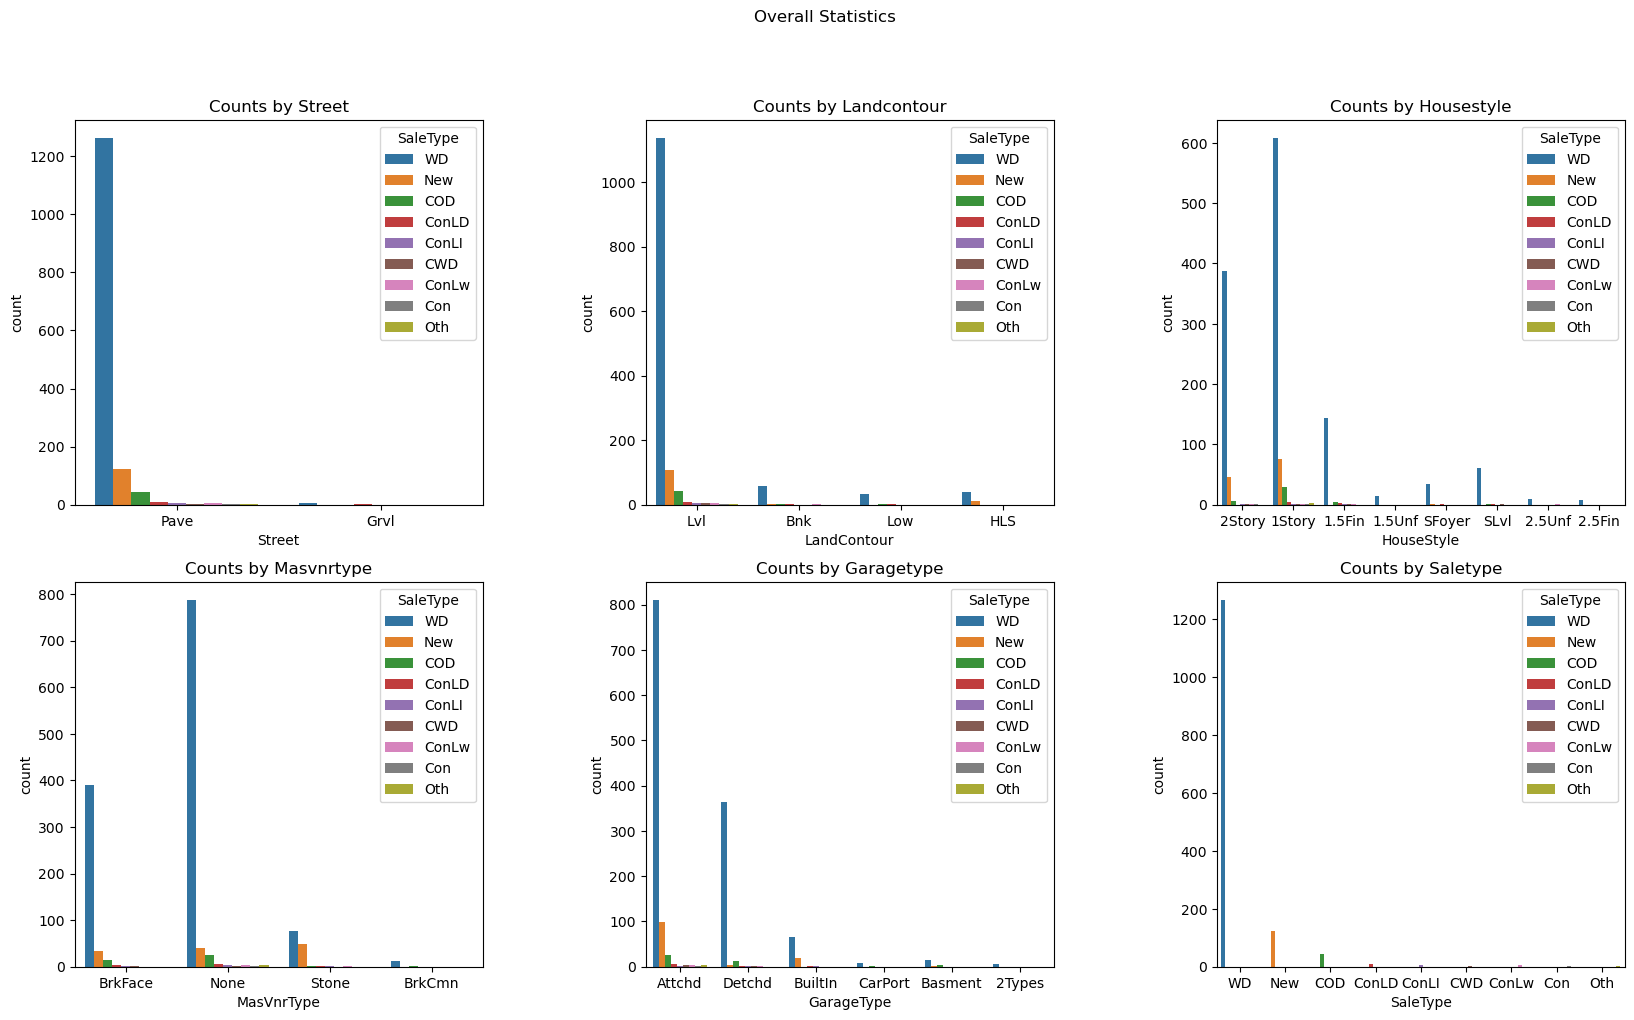

In [95]:
fig,ax=plt.subplots(2,3,figsize=(20,11))
fig.suptitle('Overall Statistics')
fig.subplots_adjust(wspace=0.4,hspace=0.2)
col_cats=['Street','LandContour','HouseStyle','MasVnrType','GarageType','SaleType']
axes=[ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
i=0
for cat in col_cats:
    sns.countplot(ax=axes[i],data=train,x=cat,hue='SaleType')    
    axes[i].set_title(f"Counts by {cat.title()}")
    i+=1

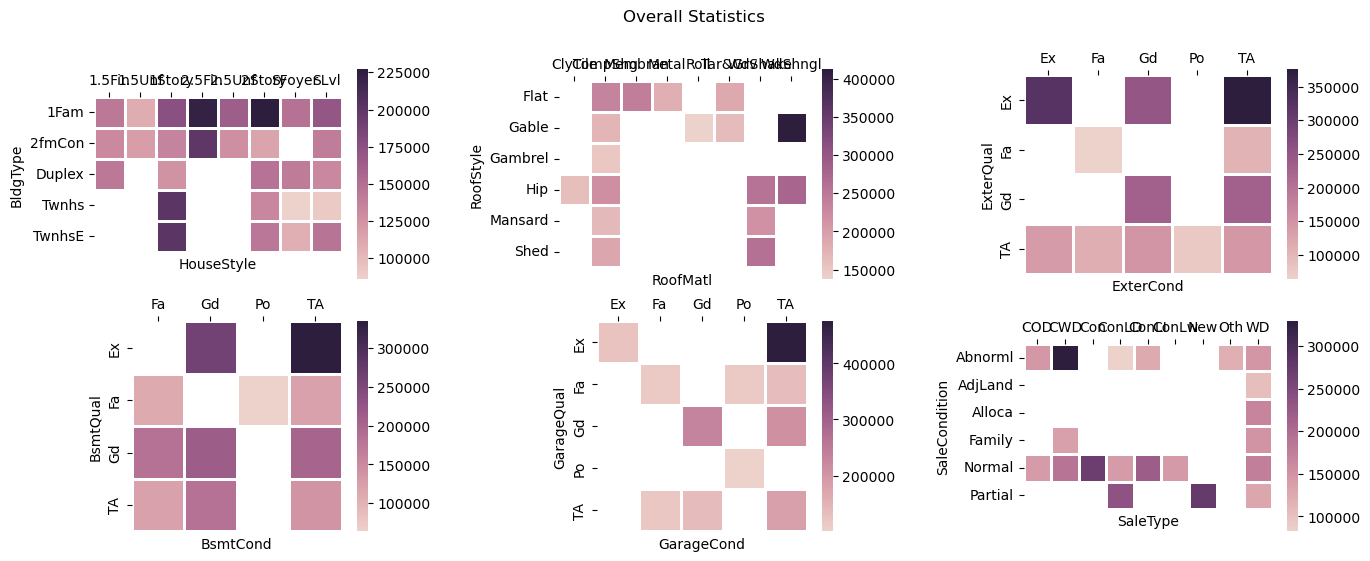

In [96]:
fig,ax=plt.subplots(2,3,figsize=(16,6))
fig.suptitle('Overall Statistics')
fig.subplots_adjust(wspace=0.5)
col_maps={'BldgType':'HouseStyle','RoofStyle':'RoofMatl','ExterQual':'ExterCond',
          'BsmtQual':'BsmtCond','GarageQual':'GarageCond','SaleCondition':'SaleType'}
axes=[ax[0,0],ax[0,1],ax[0,2],ax[1,0],ax[1,1],ax[1,2]]
j=0
for key,val in col_maps.items():
    data=train.groupby([key,val]).SalePrice.mean().unstack(level=1)
    sns.heatmap(ax=axes[j],data=data,cmap=sns.cubehelix_palette(as_cmap=True),square=True,linewidth=1)    
    axes[j].xaxis.tick_top()
    j+=1

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


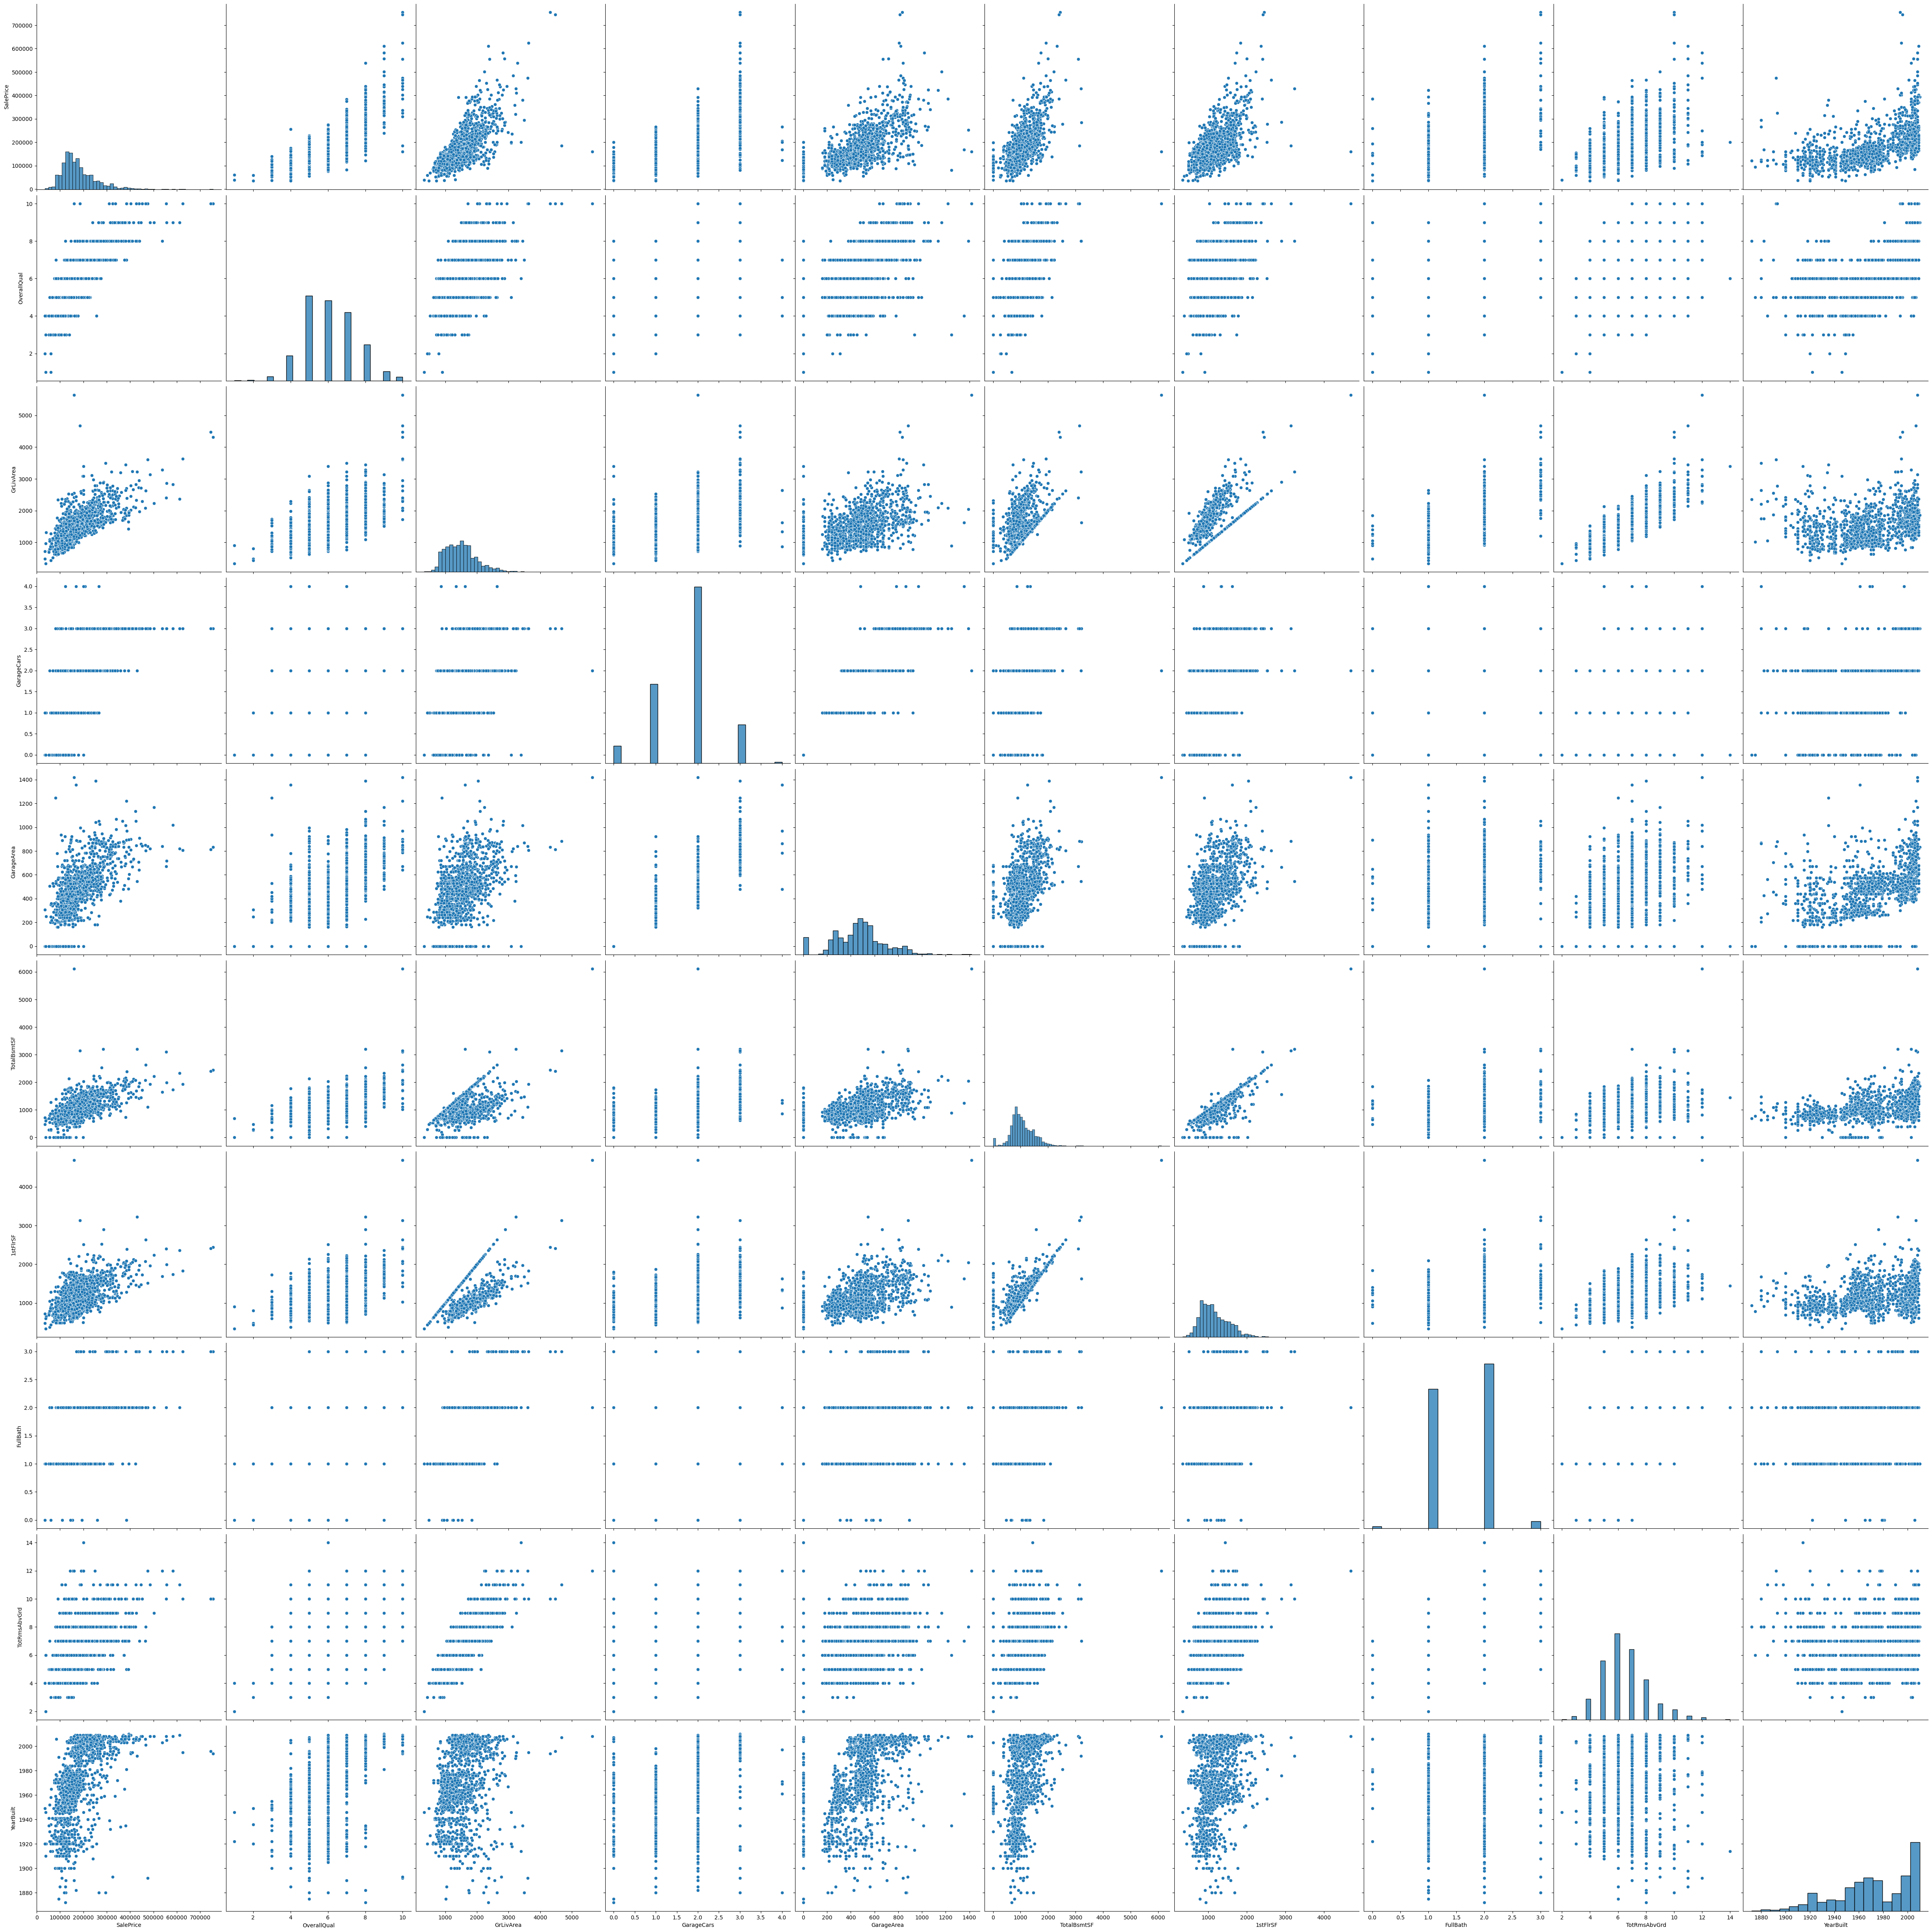

In [97]:
corr_cols=['SalePrice','OverallQual','GrLivArea','GarageCars','GarageArea',
           'TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt']
sns.pairplot(train[corr_cols],height=5)
plt.show()

# Data Preprocessing

In [98]:
train_X=train.drop('SalePrice',axis=1)
train_y=train['SalePrice']
test_X=test.copy()

In [101]:
num_pipe=Pipeline([('encoder',OrdinalEncoder()),
                   ('standard',StandardScaler())])
num_cols=[c for c in train_X.columns if train_X[c].dtype!='object']
cat_cols=[c for c in train_X.columns if train_X[c].dtype=='object']
full_pipe=ColumnTransformer([('num',num_pipe,num_cols),
                             ('cat',OrdinalEncoder(),cat_cols)])
train_prepared=full_pipe.fit_transform(train_X)
train_prepared[0]

array([ 0.2003501 , -0.27573973, -0.54921402,  0.65147924, -0.51719981,
        1.0756586 ,  0.87866809,  0.7856569 ,  0.78045541, -1.10720951,
       -0.61729831, -0.94497919,  1.21258015, -0.11460083,  0.62198326,
        1.10781015,  0.78974052,  1.22758538,  0.16541033, -0.21145358,
        0.91428906, -0.95122649,  1.03531187,  0.31172464,  0.44388107,
       -0.74903782,  0.2791173 , -0.35224718, -0.11451721, -0.25502877,
       -0.06205147, -0.16201787, -1.5991111 ,  0.13877749,  3.        ,
        1.        ,  3.        ,  3.        ,  0.        ,  4.        ,
        0.        ,  5.        ,  2.        ,  2.        ,  0.        ,
        5.        ,  1.        ,  1.        , 12.        , 13.        ,
        1.        ,  2.        ,  4.        ,  2.        ,  2.        ,
        3.        ,  3.        ,  2.        ,  5.        ,  1.        ,
        0.        ,  1.        ,  4.        ,  2.        ,  6.        ,
        1.        ,  1.        ,  4.        ,  4.        ,  2.  

In [102]:
test_prepared=full_pipe.fit_transform(test_X)
test_prepared[0]

array([-0.98133332,  0.610113  ,  0.83639063, -0.75110125,  0.40076604,
       -0.38470641, -1.07288463, -0.63986198,  0.0781487 , -0.68907436,
       -0.52607432, -0.77160775, -0.69064424, -0.08660666, -1.38963563,
       -0.83966364, -1.02871967, -0.75103955, -1.02954254, -0.20390986,
       -0.92013251, -0.89805519, -0.71078165, -1.19786798,  1.40932646,
        0.32053387, -0.749805  , -0.38775904, -0.0834751 ,  1.15162745,
       -0.05772892, -0.16237338, -0.03828073,  1.71390537,  2.        ,
        1.        ,  3.        ,  3.        ,  0.        ,  4.        ,
        0.        , 12.        ,  1.        ,  2.        ,  0.        ,
        2.        ,  1.        ,  0.        , 10.        , 12.        ,
        2.        ,  3.        ,  4.        ,  1.        ,  3.        ,
        3.        ,  3.        ,  4.        ,  3.        ,  0.        ,
        4.        ,  1.        ,  3.        ,  3.        ,  6.        ,
        1.        ,  2.        ,  3.        ,  4.        ,  2.  

# Machine Learning

#### I decided to use some Regression algorithms which is used mostly in the field

In [103]:
LR_model=LinearRegression()
DT_model=DecisionTreeRegressor()
RF_model=RandomForestRegressor(random_state=23)
XGB_model=XGBRegressor()
SVR_model=SVR()
GD_model=SGDRegressor(random_state=23)
def model_evol(model): 
    model.fit(train_prepared,train_y)
    predicted=model.predict(train_prepared)
    mae=mean_absolute_error(predicted,train_y)
    rmse=np.sqrt(np.abs(mean_squared_error(predicted,train_y)))
    r2=r2_score(predicted,train_y)*100
    return [mae,rmse,r2]

In [108]:
models=[LR_model,DT_model,RF_model,XGB_model,SVR_model,GD_model]
stats=[]
for model in models:   
    evol=model_evol(model)
    stats.append(evol)
stats    

[[18957.80351591123, 30290.188668081435, 82.97558659274758],
 [0.0, 0.0, 100.0],
 [6374.536602739726, 10888.963799041656, 97.92147832746161],
 [1216.32102151113, 1720.7479962943758, 99.95286723737976],
 [55508.508316279775, 81386.95217785906, -576031305.467186],
 [46572498.823617935, 65480216.554433376, -3.0945211780020854]]

#### You can see that Suppor Vector Machine and Gradient Boositng algorithms are showing so bad result.I remove these

In [109]:
stats=stats[:-2]

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


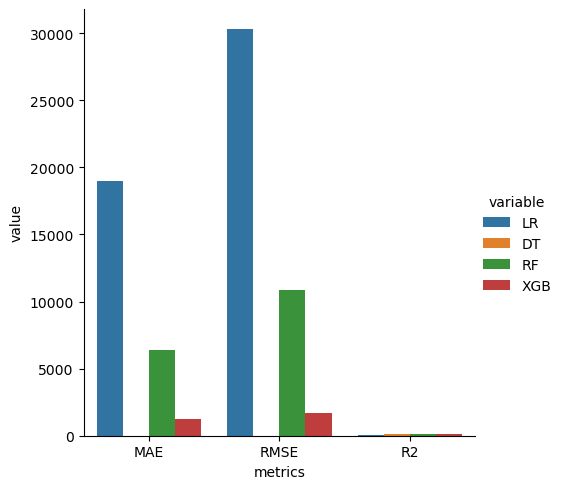

In [111]:
df_stats=pd.DataFrame(np.array(stats).T,columns=['LR','DT','RF','XGB'],index=['MAE','RMSE','R2'])
df_stats.index.name='metrics'
df_stats=df_stats.reset_index()
melted=pd.melt(df_stats,id_vars='metrics',value_vars=['LR','DT','RF','XGB'])
sns.catplot(data=melted,kind='bar',x='metrics',y='value',hue='variable')
plt.show()

#### I chose Random Forest algorithm even Decision Tree and XGboost are working properly.Because,It seems like overfitting

#### Now I use KFold cross validation which may return better result

In [112]:
train_x=pd.DataFrame(train_prepared)
kfold=KFold(n_splits=5,shuffle=True,random_state=23)
rmse_val=[]
predict_val=[]
predict_train_val=[]
for train_ix,test_ix in kfold.split(train_x):
    X_train,X_test=train_x.iloc[train_ix],train_x.iloc[test_ix]
    y_train,y_test=train_y.iloc[train_ix],train_y.iloc[test_ix]
    model=RandomForestRegressor(random_state=23)
    model.fit(X_train,y_train)
    predict_test=model.predict(X_test)
    predict_train=model.predict(train_prepared)
    predict=model.predict(test_prepared)
    rmse=np.sqrt(mean_squared_error(predict_test,y_test))
    predict_train_val.append(predict_train)
    rmse_val.append(rmse)
    predict_val.append(predict)

In [28]:
predict_kf=predict_val[rmse_val.index(min(rmse_val))]
predict_tr=predict_train_val[rmse_val.index(min(rmse_val))]
rmse_kf=np.sqrt(mean_squared_error(train_y,predict_tr))
r2_kf=r2_score(train_y,predict_tr)*100
print(f"RMSE: {rmse_kf:.2f}")
print(f"R2: {r2_kf:.2f}")

RMSE: 14052.07
R2: 96.87


In [90]:
RF=RandomForestRegressor(n_estimators=53)
RF.fit(train_prepared,train_y)
predict_t=RF.predict(train_prepared)
predict=RF.predict(test_prepared)
rmse=np.sqrt(mean_squared_error(train_y,predict_t))
r2=r2_score(train_y,predict_t)*100
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

RMSE: 11328.61
R2: 97.97


#### It is better to make prediction without KFold.Then why I change number of estimators?(Answer is below)

To improve model performance,I want to use Grid Search.Here param is n_estimators 

In [81]:
param={'n_estimators':np.arange(1,101)}
RF_gscv=GridSearchCV(RF,param,cv=5)
RF_gscv.fit(train_prepared,train_y)
RF_gscv.cv_results_

{'mean_fit_time': array([0.01794224, 0.0342638 , 0.04975505, 0.07369266, 0.08342199,
        0.09682832, 0.11515117, 0.12782817, 0.15119967, 0.15859799,
        0.17778015, 0.20388665, 0.2144753 , 0.23945789, 0.35006227,
        0.26039891, 0.27914257, 0.28873749, 0.31781549, 0.31955438,
        0.33776484, 0.35306439, 0.37008767, 0.39360604, 0.41654553,
        0.41962719, 0.43196745, 0.45528169, 0.47777061, 0.50440154,
        0.69873605, 0.54511957, 0.54726272, 0.55236893, 0.5688396 ,
        0.60517263, 0.60535989, 0.61679606, 0.650353  , 0.64820094,
        0.67865524, 0.77846551, 0.69431186, 0.70226889, 0.73100348,
        0.73875027, 0.75735378, 0.78843126, 0.78314681, 0.93257899,
        0.81542735, 0.85021858, 0.85289454, 0.87080889, 0.89821529,
        0.9085753 , 1.05270219, 0.92650509, 0.95490017, 0.95737052,
        1.00082493, 0.99014707, 1.04317255, 1.10680771, 1.05327697,
        1.05749292, 1.08154488, 1.07792311, 1.22296453, 1.13183584,
        1.14019561, 1.16948872,

In [88]:
RF_gscv.best_params_

{'n_estimators': 53}

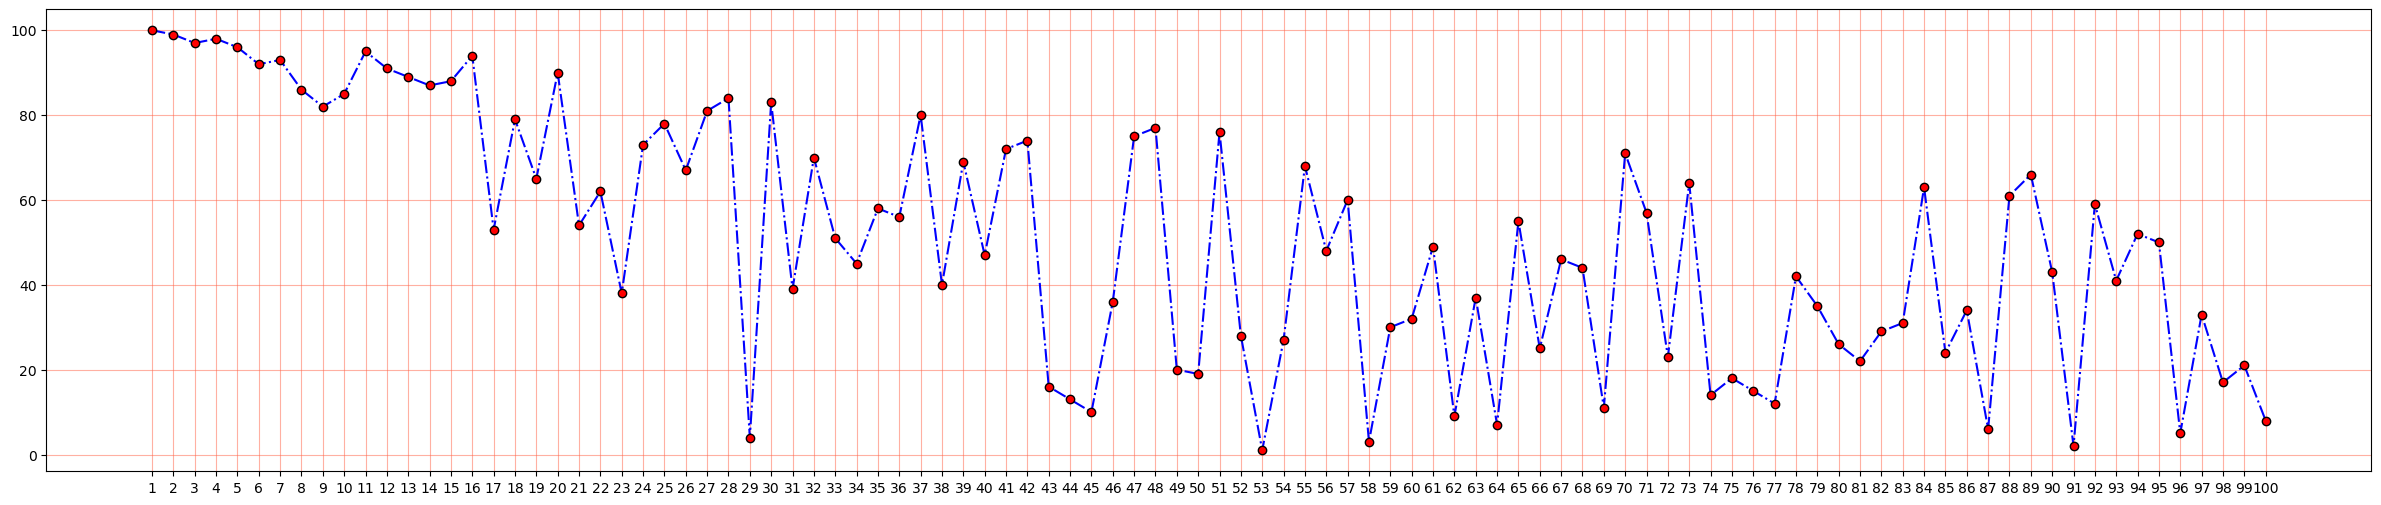

In [93]:
plt.figure(figsize=(30,6))
plt.plot(np.arange(1,101),
         RF_gscv.cv_results_['rank_test_score'],
         linewidth=1.5,linestyle='-.',color='b',
         marker='o',markerfacecolor='r',
         markeredgecolor='k')
plt.grid(color='tomato',alpha=0.5)
plt.xticks(np.arange(1,101))
#plt.yticks(np.arange(1,50))
plt.show()

#### best n_estimators is 53

In [94]:
scores=cross_val_score(estimator=RF,X=train_prepared,y=train_y,scoring='neg_mean_squared_error',cv=5)
np.sqrt(np.abs(scores))

array([27006.79805829, 30742.07349917, 30519.72590876, 24822.13610021,
       33989.04946174])

In [91]:
data=pd.DataFrame(np.array([np.arange(1461,2920),predict]).T,columns=['Id','SalePrice'])
data.Id=data.Id.astype(dtype='int64')
data.to_csv('submission_data.csv',index=False)

In [114]:
file_n='model.pkl'
with open(file_n,'wb') as file:
    pickle.dump(RF,file)